In [8]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
from torchvision import transforms

import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
import numpy as np

class PoseDataset(Dataset):
    def __init__(self, json_file, root_dir, transform=None):
        """
        Args:
            json_file (string): Path to the json file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.root_dir = root_dir
        self.transform = transform

        # Create a dictionary to map image IDs to keypoints
        self.keypoints_dict = {ann['image_id']: ann['keypoints'] for ann in self.data['annotations']}

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        img_info = self.data['images'][idx]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        # Get keypoints
        keypoints = self.keypoints_dict.get(img_info['id'], [])
        keypoints = np.array(keypoints, dtype=np.float32).reshape(-1, 3)

        # Normalize keypoints to [0, 1] range
        if len(keypoints) > 0:
            keypoints[:, 0] /= img_info['width']
            keypoints[:, 1] /= img_info['height']

        # Ensure we have 17 keypoints (51 values)
        if len(keypoints) < 17:
            padding = np.zeros((17 - len(keypoints), 3), dtype=np.float32)
            keypoints = np.vstack((keypoints, padding))
        elif len(keypoints) > 17:
            keypoints = keypoints[:17]

        keypoints = keypoints.flatten()

        if self.transform:
            image = self.transform(image)

        return image, torch.from_numpy(keypoints)

# Load pre-trained ResNet50 model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Modify the last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 51)  # 17 keypoints * 3 (x, y, visibility)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Assuming you have a custom dataset class called PoseDataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Replace these with your actual dataset paths
train_dataset = PoseDataset(json_file='/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/CCTVAnnotations.json', root_dir='/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/Images', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Training loop
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished!")

# Save the model
torch.save(model.state_dict(), '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation_git/pose_estimation_model.pth')

Epoch [1/100], Loss: 0.3584
Epoch [2/100], Loss: 0.2049
Epoch [3/100], Loss: 0.1660
Epoch [4/100], Loss: 0.1182
Epoch [5/100], Loss: 0.0819
Epoch [6/100], Loss: 0.0525
Epoch [7/100], Loss: 0.0381
Epoch [8/100], Loss: 0.0302
Epoch [9/100], Loss: 0.0244
Epoch [10/100], Loss: 0.0215
Epoch [11/100], Loss: 0.0183
Epoch [12/100], Loss: 0.0165
Epoch [13/100], Loss: 0.0168
Epoch [14/100], Loss: 0.0149
Epoch [15/100], Loss: 0.0150
Epoch [16/100], Loss: 0.0200
Epoch [17/100], Loss: 0.0203
Epoch [18/100], Loss: 0.0169
Epoch [19/100], Loss: 0.0148
Epoch [20/100], Loss: 0.0130
Epoch [21/100], Loss: 0.0108
Epoch [22/100], Loss: 0.0104
Epoch [23/100], Loss: 0.0099
Epoch [24/100], Loss: 0.0089
Epoch [25/100], Loss: 0.0081
Epoch [26/100], Loss: 0.0082
Epoch [27/100], Loss: 0.0079
Epoch [28/100], Loss: 0.0076
Epoch [29/100], Loss: 0.0072
Epoch [30/100], Loss: 0.0066
Epoch [31/100], Loss: 0.0067
Epoch [32/100], Loss: 0.0072
Epoch [33/100], Loss: 0.0064
Epoch [34/100], Loss: 0.0064
Epoch [35/100], Loss: 0

# Chat gpt bro

Training Epoch 1/100: 100%|██████████| 18/18 [00:02<00:00,  7.82it/s]


Epoch [1/100], Training Loss: 0.3826


Validation Epoch 1/100: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Epoch [1/100], Validation Loss: 0.3772


Training Epoch 2/100: 100%|██████████| 18/18 [00:02<00:00,  7.95it/s]


Epoch [2/100], Training Loss: 0.2164


Validation Epoch 2/100: 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


Epoch [2/100], Validation Loss: 0.2142


Training Epoch 3/100: 100%|██████████| 18/18 [00:02<00:00,  8.24it/s]


Epoch [3/100], Training Loss: 0.1759


Validation Epoch 3/100: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Epoch [3/100], Validation Loss: 0.2369


Training Epoch 4/100: 100%|██████████| 18/18 [00:02<00:00,  7.95it/s]


Epoch [4/100], Training Loss: 0.1312


Validation Epoch 4/100: 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


Epoch [4/100], Validation Loss: 0.2062


Training Epoch 5/100: 100%|██████████| 18/18 [00:02<00:00,  8.27it/s]


Epoch [5/100], Training Loss: 0.0868


Validation Epoch 5/100: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


Epoch [5/100], Validation Loss: 0.1878


Training Epoch 6/100: 100%|██████████| 18/18 [00:02<00:00,  7.80it/s]


Epoch [6/100], Training Loss: 0.0580


Validation Epoch 6/100: 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


Epoch [6/100], Validation Loss: 0.2062


Training Epoch 7/100: 100%|██████████| 18/18 [00:02<00:00,  7.80it/s]


Epoch [7/100], Training Loss: 0.0400


Validation Epoch 7/100: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


Epoch [7/100], Validation Loss: 0.1970


Training Epoch 8/100: 100%|██████████| 18/18 [00:02<00:00,  8.15it/s]


Epoch [8/100], Training Loss: 0.0319


Validation Epoch 8/100: 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Epoch [8/100], Validation Loss: 0.1874


Training Epoch 9/100: 100%|██████████| 18/18 [00:02<00:00,  7.85it/s]


Epoch [9/100], Training Loss: 0.0284


Validation Epoch 9/100: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Epoch [9/100], Validation Loss: 0.2099


Training Epoch 10/100: 100%|██████████| 18/18 [00:02<00:00,  7.98it/s]


Epoch [10/100], Training Loss: 0.0234


Validation Epoch 10/100: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [10/100], Validation Loss: 0.1906


Training Epoch 11/100: 100%|██████████| 18/18 [00:02<00:00,  8.24it/s]


Epoch [11/100], Training Loss: 0.0196


Validation Epoch 11/100: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


Epoch [11/100], Validation Loss: 0.1946


Training Epoch 12/100: 100%|██████████| 18/18 [00:02<00:00,  8.50it/s]


Epoch [12/100], Training Loss: 0.0172


Validation Epoch 12/100: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


Epoch [12/100], Validation Loss: 0.1934


Training Epoch 13/100: 100%|██████████| 18/18 [00:02<00:00,  8.08it/s]


Epoch [13/100], Training Loss: 0.0139


Validation Epoch 13/100: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


Epoch [13/100], Validation Loss: 0.1946


Training Epoch 14/100: 100%|██████████| 18/18 [00:02<00:00,  7.66it/s]


Epoch [14/100], Training Loss: 0.0118


Validation Epoch 14/100: 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Epoch [14/100], Validation Loss: 0.1894


Training Epoch 15/100: 100%|██████████| 18/18 [00:02<00:00,  8.09it/s]


Epoch [15/100], Training Loss: 0.0114


Validation Epoch 15/100: 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]


Epoch [15/100], Validation Loss: 0.1947


Training Epoch 16/100: 100%|██████████| 18/18 [00:02<00:00,  8.27it/s]


Epoch [16/100], Training Loss: 0.0113


Validation Epoch 16/100: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


Epoch [16/100], Validation Loss: 0.1959


Training Epoch 17/100: 100%|██████████| 18/18 [00:02<00:00,  7.75it/s]


Epoch [17/100], Training Loss: 0.0124


Validation Epoch 17/100: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


Epoch [17/100], Validation Loss: 0.1931


Training Epoch 18/100: 100%|██████████| 18/18 [00:02<00:00,  8.10it/s]


Epoch [18/100], Training Loss: 0.0116


Validation Epoch 18/100: 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


Epoch [18/100], Validation Loss: 0.1871


Training Epoch 19/100: 100%|██████████| 18/18 [00:02<00:00,  8.34it/s]


Epoch [19/100], Training Loss: 0.0123


Validation Epoch 19/100: 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]


Epoch [19/100], Validation Loss: 0.1858


Training Epoch 20/100: 100%|██████████| 18/18 [00:02<00:00,  7.66it/s]


Epoch [20/100], Training Loss: 0.0118


Validation Epoch 20/100: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


Epoch [20/100], Validation Loss: 0.1908


Training Epoch 21/100: 100%|██████████| 18/18 [00:02<00:00,  8.45it/s]


Epoch [21/100], Training Loss: 0.0118


Validation Epoch 21/100: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Epoch [21/100], Validation Loss: 0.1872


Training Epoch 22/100: 100%|██████████| 18/18 [00:02<00:00,  8.12it/s]


Epoch [22/100], Training Loss: 0.0126


Validation Epoch 22/100: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]


Epoch [22/100], Validation Loss: 0.1895


Training Epoch 23/100: 100%|██████████| 18/18 [00:02<00:00,  8.00it/s]


Epoch [23/100], Training Loss: 0.0118


Validation Epoch 23/100: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


Epoch [23/100], Validation Loss: 0.1834


Training Epoch 24/100: 100%|██████████| 18/18 [00:02<00:00,  8.09it/s]


Epoch [24/100], Training Loss: 0.0123


Validation Epoch 24/100: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


Epoch [24/100], Validation Loss: 0.1845


Training Epoch 25/100: 100%|██████████| 18/18 [00:02<00:00,  8.24it/s]


Epoch [25/100], Training Loss: 0.0108


Validation Epoch 25/100: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


Epoch [25/100], Validation Loss: 0.1878


Training Epoch 26/100: 100%|██████████| 18/18 [00:02<00:00,  7.61it/s]


Epoch [26/100], Training Loss: 0.0103


Validation Epoch 26/100: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


Epoch [26/100], Validation Loss: 0.1891


Training Epoch 27/100: 100%|██████████| 18/18 [00:02<00:00,  7.94it/s]


Epoch [27/100], Training Loss: 0.0100


Validation Epoch 27/100: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Epoch [27/100], Validation Loss: 0.1805


Training Epoch 28/100: 100%|██████████| 18/18 [00:02<00:00,  8.31it/s]


Epoch [28/100], Training Loss: 0.0103


Validation Epoch 28/100: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


Epoch [28/100], Validation Loss: 0.1871


Training Epoch 29/100: 100%|██████████| 18/18 [00:02<00:00,  7.63it/s]


Epoch [29/100], Training Loss: 0.0099


Validation Epoch 29/100: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Epoch [29/100], Validation Loss: 0.1849


Training Epoch 30/100: 100%|██████████| 18/18 [00:02<00:00,  8.28it/s]


Epoch [30/100], Training Loss: 0.0080


Validation Epoch 30/100: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Epoch [30/100], Validation Loss: 0.1906


Training Epoch 31/100: 100%|██████████| 18/18 [00:02<00:00,  7.81it/s]


Epoch [31/100], Training Loss: 0.0079


Validation Epoch 31/100: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch [31/100], Validation Loss: 0.1853


Training Epoch 32/100: 100%|██████████| 18/18 [00:02<00:00,  7.92it/s]


Epoch [32/100], Training Loss: 0.0095


Validation Epoch 32/100: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Epoch [32/100], Validation Loss: 0.1876


Training Epoch 33/100: 100%|██████████| 18/18 [00:02<00:00,  7.64it/s]


Epoch [33/100], Training Loss: 0.0090


Validation Epoch 33/100: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Epoch [33/100], Validation Loss: 0.1830


Training Epoch 34/100: 100%|██████████| 18/18 [00:02<00:00,  8.02it/s]


Epoch [34/100], Training Loss: 0.0075


Validation Epoch 34/100: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Epoch [34/100], Validation Loss: 0.1832


Training Epoch 35/100: 100%|██████████| 18/18 [00:02<00:00,  8.44it/s]


Epoch [35/100], Training Loss: 0.0070


Validation Epoch 35/100: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Epoch [35/100], Validation Loss: 0.1834


Training Epoch 36/100: 100%|██████████| 18/18 [00:02<00:00,  7.73it/s]


Epoch [36/100], Training Loss: 0.0063


Validation Epoch 36/100: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


Epoch [36/100], Validation Loss: 0.1830


Training Epoch 37/100: 100%|██████████| 18/18 [00:02<00:00,  8.33it/s]


Epoch [37/100], Training Loss: 0.0074


Validation Epoch 37/100: 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Epoch [37/100], Validation Loss: 0.1848


Training Epoch 38/100: 100%|██████████| 18/18 [00:02<00:00,  7.84it/s]


Epoch [38/100], Training Loss: 0.0074


Validation Epoch 38/100: 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Epoch [38/100], Validation Loss: 0.1861


Training Epoch 39/100: 100%|██████████| 18/18 [00:02<00:00,  8.48it/s]


Epoch [39/100], Training Loss: 0.0066


Validation Epoch 39/100: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Epoch [39/100], Validation Loss: 0.1841


Training Epoch 40/100: 100%|██████████| 18/18 [00:02<00:00,  7.84it/s]


Epoch [40/100], Training Loss: 0.0061


Validation Epoch 40/100: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch [40/100], Validation Loss: 0.1843


Training Epoch 41/100: 100%|██████████| 18/18 [00:02<00:00,  8.04it/s]


Epoch [41/100], Training Loss: 0.0063


Validation Epoch 41/100: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [41/100], Validation Loss: 0.1819


Training Epoch 42/100: 100%|██████████| 18/18 [00:02<00:00,  8.14it/s]


Epoch [42/100], Training Loss: 0.0060


Validation Epoch 42/100: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Epoch [42/100], Validation Loss: 0.1857


Training Epoch 43/100: 100%|██████████| 18/18 [00:02<00:00,  8.37it/s]


Epoch [43/100], Training Loss: 0.0065


Validation Epoch 43/100: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


Epoch [43/100], Validation Loss: 0.1835


Training Epoch 44/100: 100%|██████████| 18/18 [00:02<00:00,  8.12it/s]


Epoch [44/100], Training Loss: 0.0059


Validation Epoch 44/100: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


Epoch [44/100], Validation Loss: 0.1796


Training Epoch 45/100: 100%|██████████| 18/18 [00:02<00:00,  7.53it/s]


Epoch [45/100], Training Loss: 0.0058


Validation Epoch 45/100: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


Epoch [45/100], Validation Loss: 0.1800


Training Epoch 46/100: 100%|██████████| 18/18 [00:02<00:00,  8.15it/s]


Epoch [46/100], Training Loss: 0.0050


Validation Epoch 46/100: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Epoch [46/100], Validation Loss: 0.1860


Training Epoch 47/100: 100%|██████████| 18/18 [00:02<00:00,  8.01it/s]


Epoch [47/100], Training Loss: 0.0056


Validation Epoch 47/100: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


Epoch [47/100], Validation Loss: 0.1842


Training Epoch 48/100: 100%|██████████| 18/18 [00:02<00:00,  7.73it/s]


Epoch [48/100], Training Loss: 0.0066


Validation Epoch 48/100: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


Epoch [48/100], Validation Loss: 0.1810


Training Epoch 49/100: 100%|██████████| 18/18 [00:02<00:00,  8.19it/s]


Epoch [49/100], Training Loss: 0.0071


Validation Epoch 49/100: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Epoch [49/100], Validation Loss: 0.1860


Training Epoch 50/100: 100%|██████████| 18/18 [00:02<00:00,  7.80it/s]


Epoch [50/100], Training Loss: 0.0069


Validation Epoch 50/100: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Epoch [50/100], Validation Loss: 0.1815


Training Epoch 51/100: 100%|██████████| 18/18 [00:02<00:00,  7.64it/s]


Epoch [51/100], Training Loss: 0.0080


Validation Epoch 51/100: 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


Epoch [51/100], Validation Loss: 0.1816


Training Epoch 52/100: 100%|██████████| 18/18 [00:02<00:00,  8.43it/s]


Epoch [52/100], Training Loss: 0.0067


Validation Epoch 52/100: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Epoch [52/100], Validation Loss: 0.1817


Training Epoch 53/100: 100%|██████████| 18/18 [00:02<00:00,  7.94it/s]


Epoch [53/100], Training Loss: 0.0057


Validation Epoch 53/100: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch [53/100], Validation Loss: 0.1796


Training Epoch 54/100: 100%|██████████| 18/18 [00:02<00:00,  7.60it/s]


Epoch [54/100], Training Loss: 0.0059


Validation Epoch 54/100: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [54/100], Validation Loss: 0.1823


Training Epoch 55/100: 100%|██████████| 18/18 [00:02<00:00,  7.77it/s]


Epoch [55/100], Training Loss: 0.0064


Validation Epoch 55/100: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Epoch [55/100], Validation Loss: 0.1800


Training Epoch 56/100: 100%|██████████| 18/18 [00:02<00:00,  7.90it/s]


Epoch [56/100], Training Loss: 0.0062


Validation Epoch 56/100: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


Epoch [56/100], Validation Loss: 0.1829


Training Epoch 57/100: 100%|██████████| 18/18 [00:02<00:00,  7.60it/s]


Epoch [57/100], Training Loss: 0.0056


Validation Epoch 57/100: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


Epoch [57/100], Validation Loss: 0.1805


Training Epoch 58/100: 100%|██████████| 18/18 [00:02<00:00,  7.53it/s]


Epoch [58/100], Training Loss: 0.0052


Validation Epoch 58/100: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


Epoch [58/100], Validation Loss: 0.1804


Training Epoch 59/100: 100%|██████████| 18/18 [00:02<00:00,  7.94it/s]


Epoch [59/100], Training Loss: 0.0043


Validation Epoch 59/100: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Epoch [59/100], Validation Loss: 0.1801


Training Epoch 60/100: 100%|██████████| 18/18 [00:02<00:00,  8.24it/s]


Epoch [60/100], Training Loss: 0.0043


Validation Epoch 60/100: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


Epoch [60/100], Validation Loss: 0.1799


Training Epoch 61/100: 100%|██████████| 18/18 [00:02<00:00,  7.72it/s]


Epoch [61/100], Training Loss: 0.0047


Validation Epoch 61/100: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch [61/100], Validation Loss: 0.1815


Training Epoch 62/100: 100%|██████████| 18/18 [00:02<00:00,  8.46it/s]


Epoch [62/100], Training Loss: 0.0054


Validation Epoch 62/100: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


Epoch [62/100], Validation Loss: 0.1792


Training Epoch 63/100: 100%|██████████| 18/18 [00:02<00:00,  7.57it/s]


Epoch [63/100], Training Loss: 0.0043


Validation Epoch 63/100: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


Epoch [63/100], Validation Loss: 0.1794


Training Epoch 64/100: 100%|██████████| 18/18 [00:02<00:00,  8.09it/s]


Epoch [64/100], Training Loss: 0.0049


Validation Epoch 64/100: 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]


Epoch [64/100], Validation Loss: 0.1809


Training Epoch 65/100: 100%|██████████| 18/18 [00:02<00:00,  7.97it/s]


Epoch [65/100], Training Loss: 0.0048


Validation Epoch 65/100: 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


Epoch [65/100], Validation Loss: 0.1818


Training Epoch 66/100: 100%|██████████| 18/18 [00:02<00:00,  7.85it/s]


Epoch [66/100], Training Loss: 0.0042


Validation Epoch 66/100: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


Epoch [66/100], Validation Loss: 0.1775


Training Epoch 67/100: 100%|██████████| 18/18 [00:02<00:00,  8.14it/s]


Epoch [67/100], Training Loss: 0.0043


Validation Epoch 67/100: 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


Epoch [67/100], Validation Loss: 0.1781


Training Epoch 68/100: 100%|██████████| 18/18 [00:02<00:00,  7.77it/s]


Epoch [68/100], Training Loss: 0.0046


Validation Epoch 68/100: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Epoch [68/100], Validation Loss: 0.1785


Training Epoch 69/100: 100%|██████████| 18/18 [00:02<00:00,  8.18it/s]


Epoch [69/100], Training Loss: 0.0051


Validation Epoch 69/100: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch [69/100], Validation Loss: 0.1783


Training Epoch 70/100: 100%|██████████| 18/18 [00:02<00:00,  7.93it/s]


Epoch [70/100], Training Loss: 0.0047


Validation Epoch 70/100: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


Epoch [70/100], Validation Loss: 0.1801


Training Epoch 71/100: 100%|██████████| 18/18 [00:02<00:00,  7.34it/s]


Epoch [71/100], Training Loss: 0.0039


Validation Epoch 71/100: 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Epoch [71/100], Validation Loss: 0.1784


Training Epoch 72/100: 100%|██████████| 18/18 [00:02<00:00,  7.85it/s]


Epoch [72/100], Training Loss: 0.0041


Validation Epoch 72/100: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [72/100], Validation Loss: 0.1774


Training Epoch 73/100: 100%|██████████| 18/18 [00:02<00:00,  7.96it/s]


Epoch [73/100], Training Loss: 0.0045


Validation Epoch 73/100: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


Epoch [73/100], Validation Loss: 0.1744


Training Epoch 74/100: 100%|██████████| 18/18 [00:02<00:00,  7.96it/s]


Epoch [74/100], Training Loss: 0.0037


Validation Epoch 74/100: 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]


Epoch [74/100], Validation Loss: 0.1772


Training Epoch 75/100: 100%|██████████| 18/18 [00:02<00:00,  7.70it/s]


Epoch [75/100], Training Loss: 0.0036


Validation Epoch 75/100: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [75/100], Validation Loss: 0.1769


Training Epoch 76/100: 100%|██████████| 18/18 [00:02<00:00,  7.85it/s]


Epoch [76/100], Training Loss: 0.0036


Validation Epoch 76/100: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Epoch [76/100], Validation Loss: 0.1803


Training Epoch 77/100: 100%|██████████| 18/18 [00:02<00:00,  7.83it/s]


Epoch [77/100], Training Loss: 0.0036


Validation Epoch 77/100: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch [77/100], Validation Loss: 0.1775


Training Epoch 78/100: 100%|██████████| 18/18 [00:02<00:00,  7.87it/s]


Epoch [78/100], Training Loss: 0.0037


Validation Epoch 78/100: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Epoch [78/100], Validation Loss: 0.1807


Training Epoch 79/100: 100%|██████████| 18/18 [00:02<00:00,  7.92it/s]


Epoch [79/100], Training Loss: 0.0037


Validation Epoch 79/100: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch [79/100], Validation Loss: 0.1850


Training Epoch 80/100: 100%|██████████| 18/18 [00:02<00:00,  8.18it/s]


Epoch [80/100], Training Loss: 0.0034


Validation Epoch 80/100: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Epoch [80/100], Validation Loss: 0.1803


Training Epoch 81/100: 100%|██████████| 18/18 [00:02<00:00,  7.78it/s]


Epoch [81/100], Training Loss: 0.0037


Validation Epoch 81/100: 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Epoch [81/100], Validation Loss: 0.1807


Training Epoch 82/100: 100%|██████████| 18/18 [00:02<00:00,  8.13it/s]


Epoch [82/100], Training Loss: 0.0039


Validation Epoch 82/100: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch [82/100], Validation Loss: 0.1777


Training Epoch 83/100: 100%|██████████| 18/18 [00:02<00:00,  7.44it/s]


Epoch [83/100], Training Loss: 0.0031


Validation Epoch 83/100: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


Epoch [83/100], Validation Loss: 0.1801


Training Epoch 84/100: 100%|██████████| 18/18 [00:02<00:00,  7.90it/s]


Epoch [84/100], Training Loss: 0.0031


Validation Epoch 84/100: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch [84/100], Validation Loss: 0.1797


Training Epoch 85/100: 100%|██████████| 18/18 [00:02<00:00,  7.29it/s]


Epoch [85/100], Training Loss: 0.0026


Validation Epoch 85/100: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Epoch [85/100], Validation Loss: 0.1769


Training Epoch 86/100: 100%|██████████| 18/18 [00:02<00:00,  7.76it/s]


Epoch [86/100], Training Loss: 0.0025


Validation Epoch 86/100: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


Epoch [86/100], Validation Loss: 0.1763


Training Epoch 87/100: 100%|██████████| 18/18 [00:02<00:00,  8.12it/s]


Epoch [87/100], Training Loss: 0.0026


Validation Epoch 87/100: 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


Epoch [87/100], Validation Loss: 0.1778


Training Epoch 88/100: 100%|██████████| 18/18 [00:02<00:00,  7.94it/s]


Epoch [88/100], Training Loss: 0.0033


Validation Epoch 88/100: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Epoch [88/100], Validation Loss: 0.1792


Training Epoch 89/100: 100%|██████████| 18/18 [00:02<00:00,  8.00it/s]


Epoch [89/100], Training Loss: 0.0030


Validation Epoch 89/100: 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Epoch [89/100], Validation Loss: 0.1735


Training Epoch 90/100: 100%|██████████| 18/18 [00:02<00:00,  8.63it/s]


Epoch [90/100], Training Loss: 0.0026


Validation Epoch 90/100: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [90/100], Validation Loss: 0.1786


Training Epoch 91/100: 100%|██████████| 18/18 [00:02<00:00,  8.20it/s]


Epoch [91/100], Training Loss: 0.0030


Validation Epoch 91/100: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Epoch [91/100], Validation Loss: 0.1783


Training Epoch 92/100: 100%|██████████| 18/18 [00:02<00:00,  8.32it/s]


Epoch [92/100], Training Loss: 0.0033


Validation Epoch 92/100: 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


Epoch [92/100], Validation Loss: 0.1753


Training Epoch 93/100: 100%|██████████| 18/18 [00:02<00:00,  8.24it/s]


Epoch [93/100], Training Loss: 0.0033


Validation Epoch 93/100: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


Epoch [93/100], Validation Loss: 0.1757


Training Epoch 94/100: 100%|██████████| 18/18 [00:02<00:00,  7.94it/s]


Epoch [94/100], Training Loss: 0.0033


Validation Epoch 94/100: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Epoch [94/100], Validation Loss: 0.1769


Training Epoch 95/100: 100%|██████████| 18/18 [00:02<00:00,  8.34it/s]


Epoch [95/100], Training Loss: 0.0039


Validation Epoch 95/100: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Epoch [95/100], Validation Loss: 0.1783


Training Epoch 96/100: 100%|██████████| 18/18 [00:02<00:00,  8.04it/s]


Epoch [96/100], Training Loss: 0.0048


Validation Epoch 96/100: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [96/100], Validation Loss: 0.1801


Training Epoch 97/100: 100%|██████████| 18/18 [00:02<00:00,  8.31it/s]


Epoch [97/100], Training Loss: 0.0042


Validation Epoch 97/100: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Epoch [97/100], Validation Loss: 0.1800


Training Epoch 98/100: 100%|██████████| 18/18 [00:02<00:00,  8.19it/s]


Epoch [98/100], Training Loss: 0.0032


Validation Epoch 98/100: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Epoch [98/100], Validation Loss: 0.1831


Training Epoch 99/100: 100%|██████████| 18/18 [00:02<00:00,  8.18it/s]


Epoch [99/100], Training Loss: 0.0033


Validation Epoch 99/100: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


Epoch [99/100], Validation Loss: 0.1798


Training Epoch 100/100: 100%|██████████| 18/18 [00:02<00:00,  7.61it/s]


Epoch [100/100], Training Loss: 0.0030


Validation Epoch 100/100: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Epoch [100/100], Validation Loss: 0.1747
Training finished!


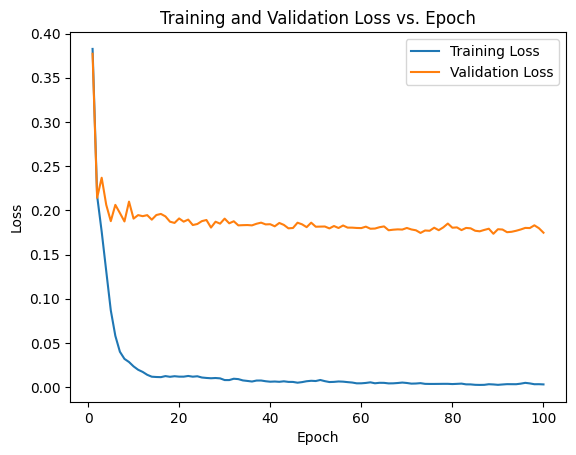

In [6]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

import json
import os
from PIL import Image
import numpy as np

class PoseDataset(Dataset):
    def __init__(self, json_file, root_dir, transform=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.root_dir = root_dir
        self.transform = transform

        # Create a dictionary to map image IDs to keypoints
        self.keypoints_dict = {ann['image_id']: ann['keypoints'] for ann in self.data['annotations']}

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        img_info = self.data['images'][idx]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        # Get keypoints
        keypoints = self.keypoints_dict.get(img_info['id'], [])
        keypoints = np.array(keypoints, dtype=np.float32).reshape(-1, 3)

        # Normalize keypoints to [0, 1] range
        if len(keypoints) > 0:
            keypoints[:, 0] /= img_info['width']
            keypoints[:, 1] /= img_info['height']

        # Ensure we have 17 keypoints (51 values)
        if len(keypoints) < 17:
            padding = np.zeros((17 - len(keypoints), 3), dtype=np.float32)
            keypoints = np.vstack((keypoints, padding))
        elif len(keypoints) > 17:
            keypoints = keypoints[:17]

        keypoints = keypoints.flatten()

        if self.transform:
            image = self.transform(image)

        return image, torch.from_numpy(keypoints)

# Load pre-trained ResNet50 model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Modify the last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 51)  # 17 keypoints * 3 (x, y, visibility)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Assuming you have a custom dataset class called PoseDataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Replace these with your actual dataset paths
dataset = PoseDataset(json_file='/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/CCTVAnnotations.json', root_dir='/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/Images', transform=transform)

# Split the dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Training loop
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

print("Training finished!")

# Save the model
torch.save(model.state_dict(), '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation_git/pose_estimation_model.pth')

# Plot training and validation loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss vs. Epoch')
plt.show()


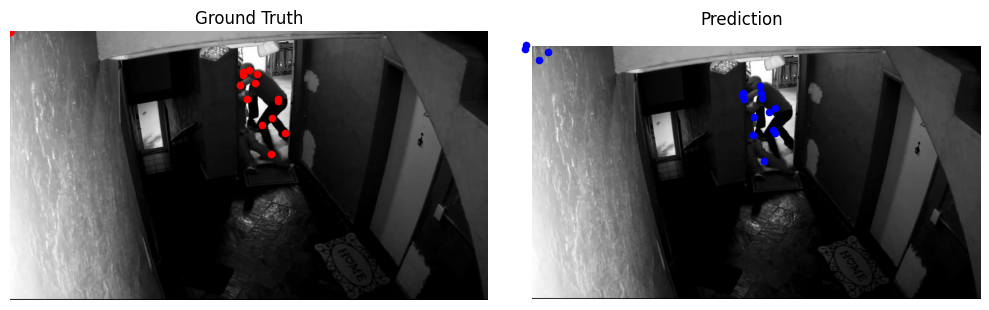

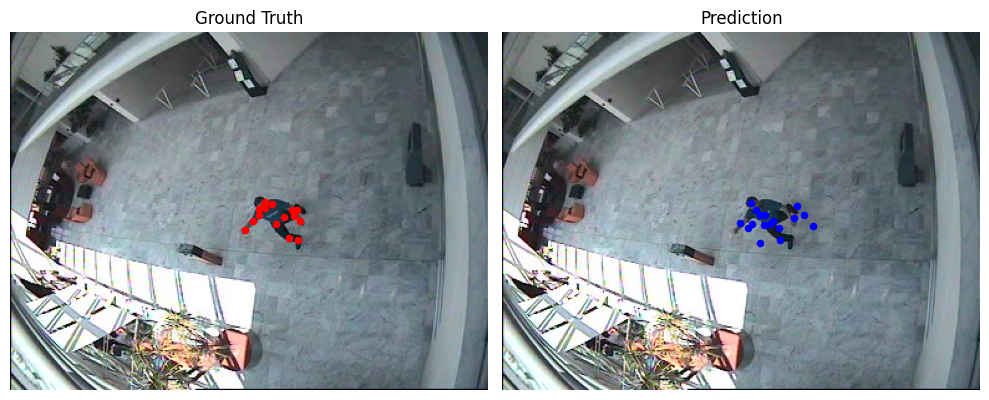

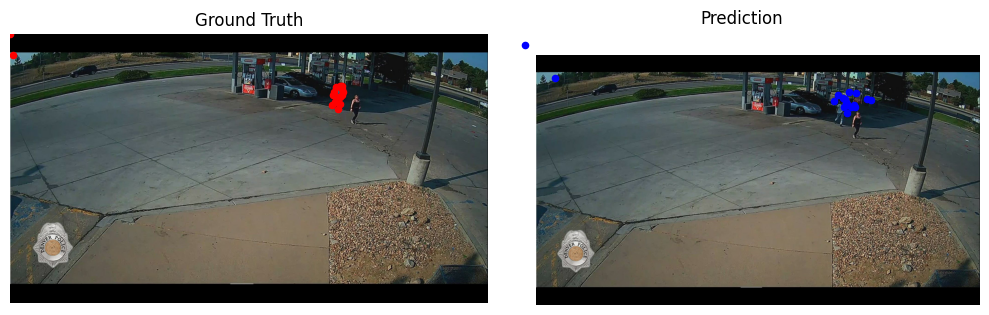

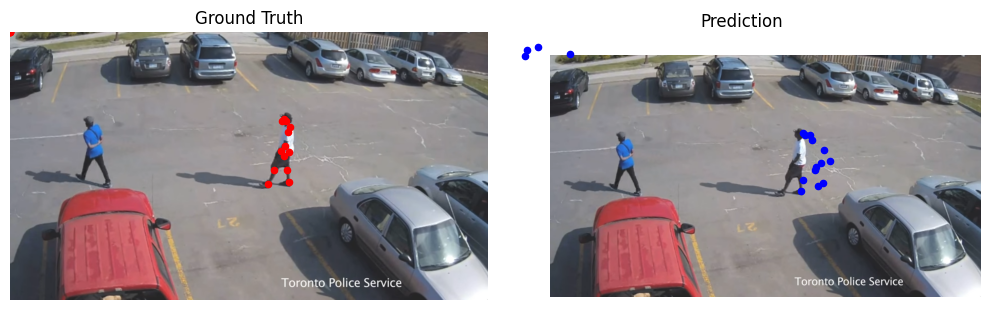

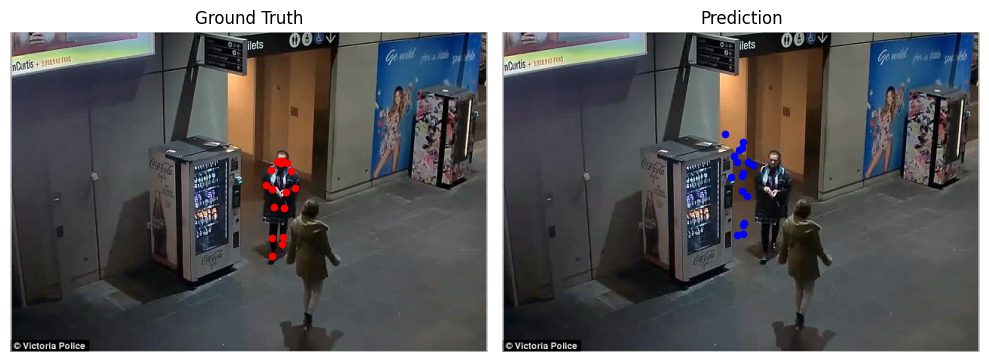

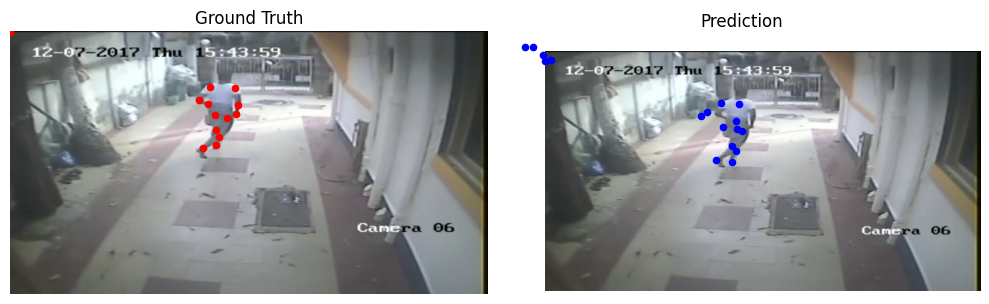

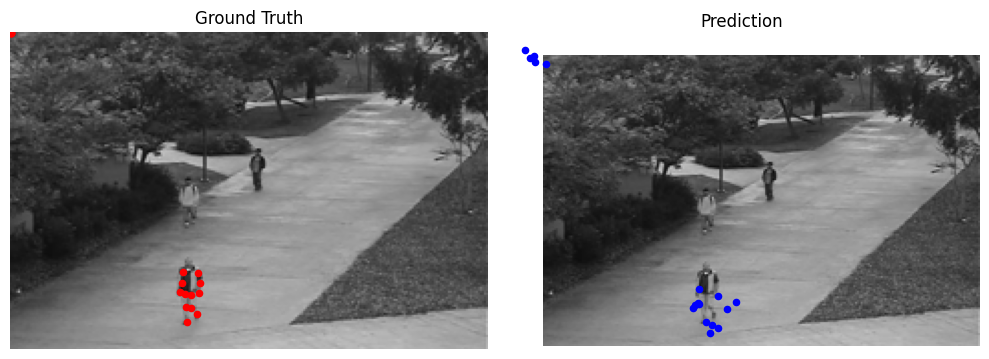

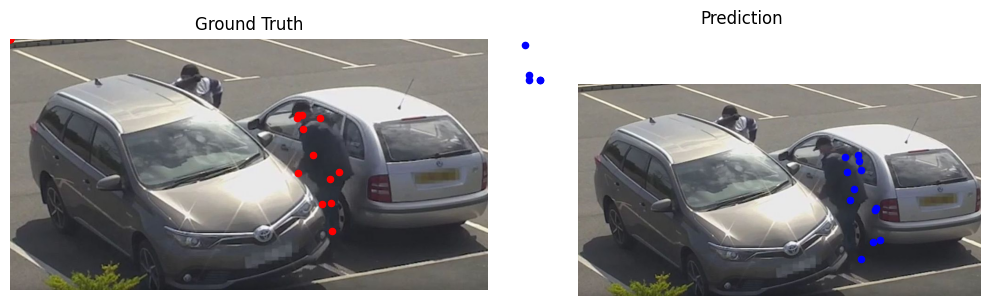

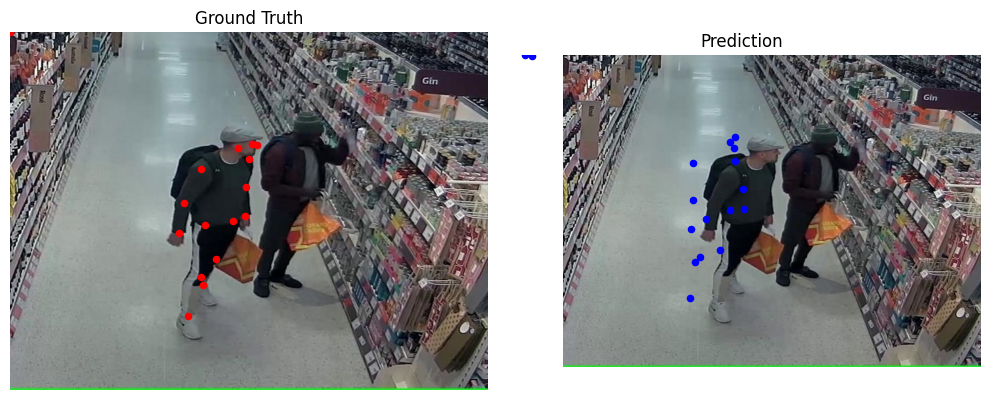

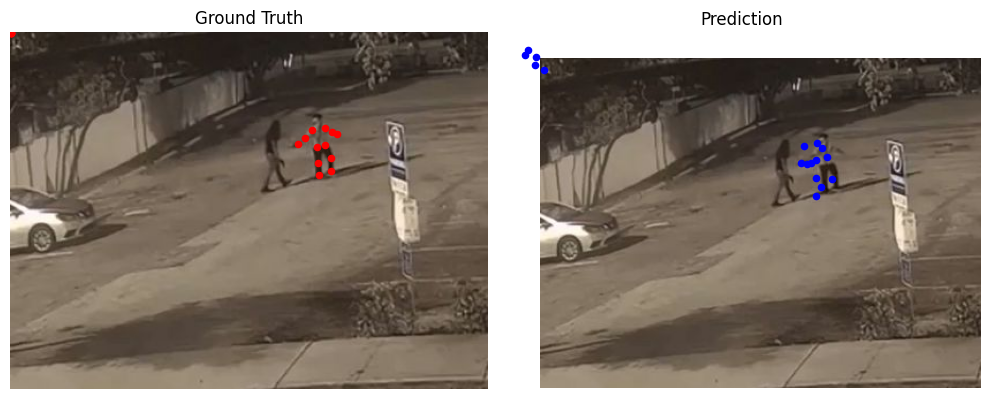

In [10]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


class PoseDataset(Dataset):
    def __init__(self, json_file, root_dir, transform=None):
        """
        Args:
            json_file (string): Path to the json file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.root_dir = root_dir
        self.transform = transform

        # Create a dictionary to map image IDs to keypoints
        self.keypoints_dict = {ann['image_id']: ann['keypoints'] for ann in self.data['annotations']}

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        img_info = self.data['images'][idx]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        # Get keypoints
        keypoints = self.keypoints_dict.get(img_info['id'], [])
        keypoints = np.array(keypoints, dtype=np.float32).reshape(-1, 3)

        # Normalize keypoints to [0, 1] range
        if len(keypoints) > 0:
            keypoints[:, 0] /= img_info['width']
            keypoints[:, 1] /= img_info['height']

        # Ensure we have 17 keypoints (51 values)
        if len(keypoints) < 17:
            padding = np.zeros((17 - len(keypoints), 3), dtype=np.float32)
            keypoints = np.vstack((keypoints, padding))
        elif len(keypoints) > 17:
            keypoints = keypoints[:17]

        keypoints = keypoints.flatten()

        if self.transform:
            image = self.transform(image)

        return image, torch.from_numpy(keypoints)

# Load the trained model
model = resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 51)
model.load_state_dict(torch.load('/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation_git/pose_estimation_model.pth'))
model.eval()

# Define the same transform you used for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset
dataset = PoseDataset(json_file='/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/CCTVAnnotations.json', 
                      root_dir='/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/Images', 
                      transform=None)  # No transform here, we'll apply it separately

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# def visualize_keypoints(image, keypoints, predicted_keypoints):
#     plt.figure(figsize=(10, 5))
    
#     # Plot original image with ground truth keypoints
#     plt.subplot(1, 2, 1)
#     plt.imshow(image)
#     plt.scatter(keypoints[0::3] * image.width, keypoints[1::3] * image.height, c='r', s=20)
#     plt.title('Ground Truth')
#     plt.axis('off')
    
#     # Plot original image with predicted keypoints
#     plt.subplot(1, 2, 2)
#     plt.imshow(image)
#     plt.scatter(predicted_keypoints[0::3] * image.width, 
#                 predicted_keypoints[1::3] * image.height, c='b', s=20)
#     plt.title('Prediction')
#     plt.axis('off')
    
#     plt.tight_layout()
#     plt.show()

def visualize_keypoints(image, keypoints, predicted_keypoints, model_size=(224, 224)):
    plt.figure(figsize=(10, 5))
    
    # Calculate scale factors
    scale_x = image.width / model_size[0]
    scale_y = image.height / model_size[1]
    
    # Plot original image with ground truth keypoints
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.scatter(keypoints[0::3] * image.width, keypoints[1::3] * image.height, c='r', s=20)
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Plot original image with predicted keypoints
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.scatter(predicted_keypoints[0::3] * model_size[0] * scale_x, 
                predicted_keypoints[1::3] * model_size[1] * scale_y, c='b', s=20)
    plt.title('Prediction')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# for i in range(10):  # Visualize first 10 images
#     image, keypoints = dataset[i]
    
#     # Prepare image for model input
#     input_tensor = transform(image).unsqueeze(0).to(device)
    
#     # Get model prediction
#     with torch.no_grad():
#         output = model(input_tensor)
    
#     # Convert output to numpy array
#     predicted_keypoints = output.squeeze().cpu().numpy()
    
#     # Visualize
#     visualize_keypoints(image, keypoints.numpy(), predicted_keypoints)


for i in range(10):  # Visualize first 10 images
    image, keypoints = dataset[i]
    
    # Get original image size
    original_size = image.size
    
    # Prepare image for model input
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
    
    # Convert output to numpy array
    predicted_keypoints = output.squeeze().cpu().numpy()
    
    # Visualize
    visualize_keypoints(image, keypoints.numpy(), predicted_keypoints, model_size=(224, 224))